In [36]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
pip install yfinance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime


In [39]:
n=input("Enter Stock name:") #AAPL, GOOG, MSFT, AMZN
df = yf.Ticker(n).history(period='3y').reset_index()
df

Enter Stock name:AAPL


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-08-19,51.515828,52.031916,51.371520,51.449791,97654400,0.0,0.0
1,2019-08-20,51.579421,52.183562,51.442450,51.452232,107537200,0.0,0.0
2,2019-08-21,52.095511,52.256939,51.755530,52.009903,86141600,0.0,0.0
3,2019-08-22,52.144432,52.450171,51.547628,51.965881,89014800,0.0,0.0
4,2019-08-23,51.224769,51.865601,49.162866,49.563995,187272000,0.0,0.0
...,...,...,...,...,...,...,...,...
751,2022-08-11,170.059998,170.990005,168.190002,168.490005,57149200,0.0,0.0
752,2022-08-12,169.820007,172.169998,169.399994,172.100006,67946400,0.0,0.0
753,2022-08-15,171.520004,173.389999,171.350006,173.190002,54091700,0.0,0.0
754,2022-08-16,172.779999,173.710007,171.660004,173.029999,56180100,0.0,0.0


### OHLC Chart




In [40]:
import plotly.io as pio
pio.renderers.default = "colab"

In [41]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df["Date"],
                      open=df["Open"],
                      high=df["High"],
                      low=df["Low"],
                      close=df["Close"],
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

####Decomposition:




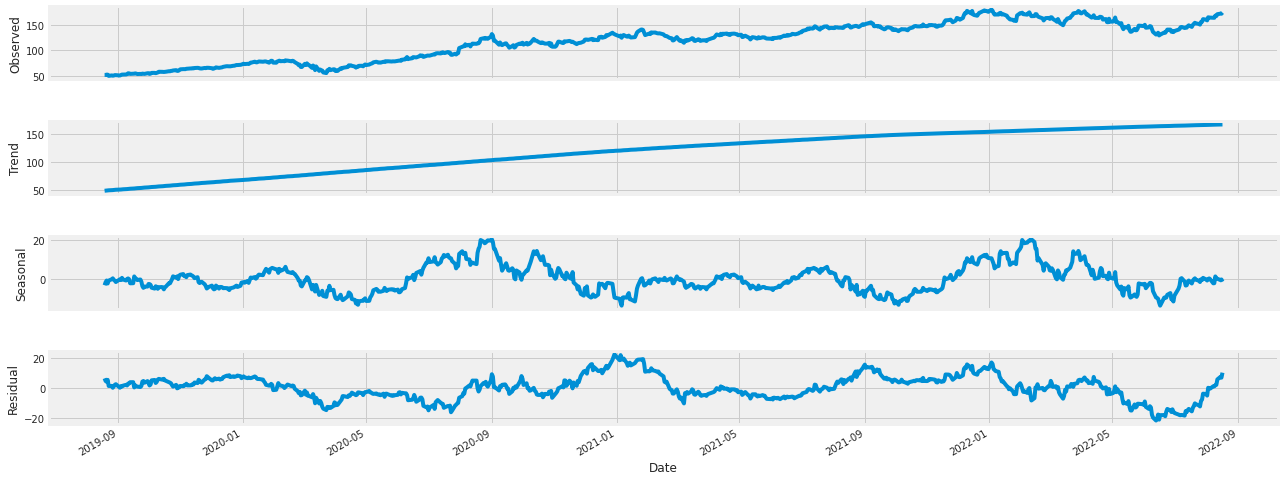

In [42]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

### Technical indicators

#### Moving Averages

Calculating few moving averages to be used as features: SMA5 , SMA10, SMA15, SMA30 and EMA9


In [43]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index
Adding RSI indicator to predict whether a stock is overbought/oversold.

In [44]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)
fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [45]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [46]:
df['Close'] = df['Close'].shift(-1)

Clean data by removing invalid samples

In [47]:
df1=df

In [48]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))


Splitting the stock data into: <br>
70% Training <br>
15% Validation <br>
15% Test

In [49]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [50]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

### Split into features and labels

In [51]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Dividends     506 non-null    float64
 1   Stock Splits  506 non-null    float64
 2   EMA_9         506 non-null    float64
 3   SMA_5         506 non-null    float64
 4   SMA_10        506 non-null    float64
 5   SMA_15        506 non-null    float64
 6   SMA_30        506 non-null    float64
 7   RSI           506 non-null    float64
 8   MACD          506 non-null    float64
 9   MACD_signal   506 non-null    float64
dtypes: float64(10)
memory usage: 39.7 KB


In [52]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=False)

[18:10:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

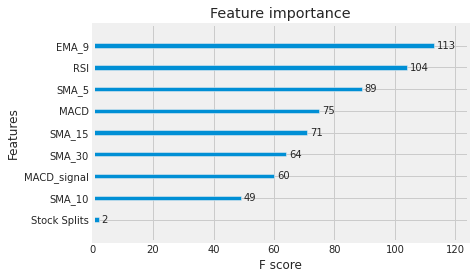

In [53]:
plot_importance(model);

### Calculate and visualize predictions

In [54]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
accuracy=((y_pred.mean()/y_test.mean()))*100
print("Accuracy:",accuracy)

y_true = [154.64764404 159.1348114  160.16188049 163.51228333 164.90830994]
y_pred = [144.09009 144.31175 145.61049 144.31175 145.76447]
mean_squared_error = 214.5006540973964
Accuracy: 93.70872677042027


In [55]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [56]:
from sklearn.linear_model import LinearRegression
lin=LinearRegression().fit(X_train,y_train)

In [57]:
y_pred = lin.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')


y_true = [154.64764404 159.1348114  160.16188049 163.51228333 164.90830994]
y_pred = [152.80318503 153.78024105 156.93732475 160.64012536 164.4105743 ]
mean_squared_error = 12.650712578960258


In [58]:
if(y_pred.mean()>y_test.mean()):
  d=y_pred.mean()-y_test.mean()
  accuracy=((y_test.mean()-d)/y_test.mean())*100
else:
  accuracy=((y_pred.mean()/y_test.mean()))*100
print("Accuracy:",accuracy)


Accuracy: 99.93287052939303


In [59]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [61]:
df1['SMA_5'] = df1['Close'].rolling(5).mean().shift()
df1['SMA_10'] = df1['Close'].rolling(10).mean().shift()


####Alert System:

In [62]:
a=df1['SMA_5'].get(len(df1['SMA_5'])-1)
b=df1['Open'].get(len(df1['Open'])-1)
c=b-a
d=(df1['SMA_10'].get(len(df1['SMA_10'])-1) - df1['Open'].get(len(df1['Open'])-1))
if(c>=3):
  print(c,"is the difference between Moving Average for 5 days and Open, You should Sell")
elif(c<=-3):
   print(c,"is the difference between Moving Average for 5 days and Open, You should Buy")
else:
  print("The difference between the Moving Average for 5 days and Open is",c)
if(d>=3):
  print(d,"is the difference between Moving Average for 10 days and Open, You should Sell")
elif(d<=-3):
   print(d,"is the difference between Moving Average for 10 days and Open, You should Buy")
else:
  print("The difference between the Moving Average for 10 days and Open is",d)


The difference between the Moving Average for 5 days and Open is 0.3440002441406307
-3.561001586914074 is the difference between Moving Average for 10 days and Open, You should Buy


####Make Your Prediction Here: 
Enter in the format: <br>
'Dividends', 'Stock Splits', 'EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'


In [63]:
df2 = pd.DataFrame(columns = ['Dividends', 'Stock Splits', 'EMA_9', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal'])
df2.loc[0] = [0.0,	0.0,	154.077849,	161.277979,	157.610074,	154.987383,	148.173846,	72.355610,	5.294613,	4.060149] 
lin.predict(df2)

array([165.1091034])